In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import pickle

# Extracts details from the metadata associated with a swap ID.
def getSwapDetails(swap_metadata):
    chain = swap_metadata["chain"].iloc[0]
    dex = swap_metadata["dex"].iloc[0]
    token_in = swap_metadata["token_in_symbol"].iloc[0]
    token_out = swap_metadata["token_out_symbol"].iloc[0]
    return chain, dex, token_in, token_out


# Expands a list of swap IDs into a list of dictionaries with the metadata associated
#   with each swap ID.
def swapsIDsToPath(swap_ids):
    details = []
    for id in swap_ids:
        if id == 0:
            continue

        chain, dex, token_in, token_out = getSwapDetails(
            opps_metadata_df.loc[opps_metadata_df["swap_id"] == id]
        )

        details.append(
            {"chain": chain, "dex": dex, "token_in": token_in, "token_out": token_out}
        )

    return details


# Converts a path from a csv string to a list.
def convertStringToList(path):
    return [int(float(k)) for k in path[1:-1].split(",")]

print("Loading path data...")
opps_df = pd.read_csv("assets/opps_cleaned-2023-3-19.csv").reset_index(drop=True)
opps_metadata_df = pd.read_csv("assets/opps_metadata-2023-3-19.csv").reset_index(drop=True)
print("Finished loading path data!")

print("Searching for unique paths in `opps_df` archive...")
unique_paths = opps_df[
    ["swap_1_id", "swap_2_id", "swap_3_id", "swap_4_id"]
].drop_duplicates()
unique_paths.reset_index(inplace=True)
# print(unique_paths)
print("Finsihed searching for unique paths in `opps_df` archive!")

print(
    "Collect statistics about which chains, DEXs, and tokens are involved in the opportunities."
)
stats = {}
for _, key in unique_paths.iterrows():
    # A `swap_id` corresponds to a unique pair contract. It is unique to a specific
    #   chain, DEX, and token pair.
    for swap_id in [
        key["swap_1_id"],
        key["swap_2_id"],
        key["swap_3_id"],
        key["swap_4_id"],
    ]:
        if swap_id == 0.0:
            continue

        metadata = opps_metadata_df[opps_metadata_df["swap_id"] == swap_id]
        chain = metadata["chain"].iloc[0]

        if chain not in stats.keys():
            stats[chain] = {"dexes": [], "tokens": []}

        dex = metadata["dex"].iloc[0]
        if dex not in stats[chain]["tokens"]:
            stats[chain]["tokens"].append(metadata["dex"].iloc[0])

        token = metadata["token_in_symbol"].iloc[0]
        if token not in stats[chain]["dexes"]:
            stats[chain]["dexes"].append(metadata["token_in_symbol"].iloc[0])

# A token pair is often involved in multiple opportunities for a given block.
#   Ignore "inferior" opportunities that occur at the same timestamp as better ones.

# Get unique timestamps from `opps_df` archive.
unique_timestamps = opps_df["timestamp"].unique()

# Track the valid opportunities at each unique timestamp.
print("Finding valid opportunities")
valid_opps = {}
for i, timestamp in enumerate(unique_timestamps):
    if np.isnan(timestamp):
        # This timestamp is invalid.
        # print("found nan!")
        continue

    # Get opportunities that happen at the same time. Sort them by profit.
    opps_simultaneous = opps_df[opps_df["timestamp"] == timestamp].sort_values(
        by="profit_usd", ascending=False
    )

    valid_opps[timestamp] = []

    # Track the swap IDs used at this timestamp. Only keep the opportunities that don't have
    #   conflicting swap IDs.
    swap_ids_used = set()
    for j, opp in opps_simultaneous.iterrows():
        valid = 1
        swap_ids = opp[["swap_1_id", "swap_2_id", "swap_3_id", "swap_4_id"]].to_list()
        for id in swap_ids:
            # `swap_3_id` and `swap_4_id` could be 0 if not used. No need to track those.
            if id == 0:
                break
            # This ID is not used yet, so it is valid.
            elif id not in swap_ids_used:
                continue
            # This ID is used already, and it is conflicting with a greater opportunity.
            else:
                # No need to look further because this opportunity is inferior.
                valid = 0
                break

        # Add the swap ID to the set of used ones.
        if valid:
            swap_ids_used = swap_ids_used.union(set(swap_ids))
            valid_opps[timestamp].append(opp)
        else:
            pass


# Block rate (in seconds) for each chain that we track.
block_rate = {
    'polygon':2,
    'ethereum':12,
    'bsc':3,
    'fantom':3,
    'avalanche':1,
    'gnosis':5,
    'arbitrum':1,
    'optimism':2
}

# Track the timestamps, profits, and block numbers where each opportunity occurs. 
path_data = {}
for timestamp, opps in valid_opps.items():
    for opp in opps: 
        path = str(opp[['swap_1_id', 'swap_2_id', 'swap_3_id', 'swap_4_id']].to_list())

        # Maps chains to the block numbers for the current opportunity
        block_numbers = opp[['swap_1_block', 'swap_2_block', 'swap_3_block', 'swap_4_block']].tolist()
        
        if path not in path_data:
            path_data[path] = {
                'timestamps': [timestamp], 
                'profit_usd': [opp['profit_usd']],
                'block_numbers': [block_numbers]
            }
        else:
            path_data[path]['timestamps'].append(timestamp)
            path_data[path]['profit_usd'].append(opp['profit_usd'])
            path_data[path]['block_numbers'].append(block_numbers)

# Sort the `path_data` by timestamps. Basically gets us a time series version of the data.
for path, data in path_data.items():
    timestamps = data['timestamps']
    profits = data['profit_usd']
    path_data[path]['timestamps'], path_data[path]['profits_usd'] = (
        list(t) for t in zip(*sorted(zip(timestamps, profits)))
    )

# Stores opportunity clusters, which are clustered by relative profit and time.
unique_opps_profit_time = {}

# Loop through each path and assign its opportunities to a cluster.
for path, data in path_data.items():

    # Initialize the clustering dictionary for this path.
    unique_opps_profit_time[path] = {
        'profits':[],
        'timestamps': []
    }

    # Get the swap IDs used in the path.
    swap_ids = convertStringToList(path) 
    
    # Find the slowest chain in the path.
    slowest_block = 0
    for id in swap_ids:
        if id == 0:
            break

        # Get the chain name corresponding to the swap ID: Ethereum, Polygon, etc.
        chain_name = opps_metadata_df[opps_metadata_df['swap_id'] == id]['chain'].iloc[0]

        # Check if the current chain is the slowest in the path.
        if block_rate[chain_name] > slowest_block:
            slowest_block = block_rate[chain_name]
            slowest_chain = chain_name

    # Find all the opportunities and how long they persist when clustered.
    timestamps = data['timestamps']
    profits = data['profit_usd']
    profit_reference = profits[0] 
    time_reference = timestamps[0]

    # Variables used to track the current opportunity cluster.
    cluster_profits = [profits[0]]
    cluster_timestamps = [timestamps[0]]

    # Assign all opportunities in this path to a cluster.
    for i in range(1, len(timestamps)):
        current_profit = profits[i]
        current_time = timestamps[i]
        
        # If this opportunity is too different from the last opportunity in the current cluster, 
        #  store the current cluster and start a new one.

        # Current opportunity can be at most 10% different from the last opportunity in the cluster.
        propotion = current_profit / profit_reference
        max_deviation = .1

        # Current opportunity can be at most 100 seconds later than the last opportunity in the cluster.
        delta = current_time - time_reference 
        max_delta = 100

        # The following `if` logic runs whenever we need to store a cluster
        if propotion < (1 - max_deviation) or propotion > (1 + max_deviation) or delta > max_delta: 
            # Store the details of the current opportunity
            unique_opps_profit_time[path]['profits'].append(cluster_profits)
            unique_opps_profit_time[path]['timestamps'].append(cluster_timestamps)

            # Reset variables used to track next opportunity
            cluster_profits = [profits[i]]
            cluster_timestamps = [timestamps[i]]
        # The following logic runs when we assign an opportunity to an existing cluster
        else:
            cluster_profits.append(profits[i])
            cluster_timestamps.append(timestamps[i])
        
        # Reset the reference points
        profit_reference = current_profit
        time_reference = current_time

# Save all the variables to a binary file.
print("Saving variables...")
with open('assets/opps.pkl', 'wb') as f:
    pickle.dump(opps_df, f)

with open('assets/opps_metadata_df.pkl', 'wb') as f:
    pickle.dump(opps_metadata_df, f)

with open('assets/path_data.pkl', 'wb') as f:
    pickle.dump(path_data, f)

with open('assets/unique_opps_profit_time.pkl', 'wb') as f:
    pickle.dump(unique_opps_profit_time, f)

with open('assets/unique_paths.pkl', 'wb') as f:
    pickle.dump(unique_paths, f)

with open('assets/unique_timestamps.pkl', 'wb') as f:
    pickle.dump(unique_timestamps, f)

with open('assets/block_rate.pkl', 'wb') as f:
    pickle.dump(block_rate, f)

with open('assets/stats.pkl', 'wb') as f:
    pickle.dump(stats, f)


Loading path data...
Finished loading path data!
Searching for unique paths in `opps_df` archive...
Finsihed searching for unique paths in `opps_df` archive!
Collect statistics about which chains, DEXs, and tokens are involved in the opportunities.
Finding valid opportunities
Saving variables...


In [5]:
import numpy as np
import pandas as pd
from datetime import datetime
import pickle

global opps_df
global opps_metadata_df
global path_data
global unique_opps_profit_time
global unique_paths
global unique_timestamps
global block_rate
global stats

print("Loading variables from .pkl files...")
with open('assets/opps.pkl', 'rb') as f:
    opps_df = pickle.load(f)

with open('assets/opps_metadata_df.pkl', 'rb') as f:
    opps_metadata_df = pickle.load(f)

with open('assets/path_data.pkl', 'rb') as f:
    path_data = pickle.load(f)

with open('assets/unique_opps_profit_time.pkl', 'rb') as f:
    unique_opps_profit_time = pickle.load(f)

with open('assets/unique_paths.pkl', 'rb') as f:
    unique_paths = pickle.load(f)

with open('assets/unique_timestamps.pkl', 'rb') as f:
    unique_timestamps = pickle.load(f)

with open('assets/block_rate.pkl', 'rb') as f:
    block_rate = pickle.load(f)

with open('assets/stats.pkl', 'rb') as f:
    stats = pickle.load(f)
print("Finished loading variables from .pkl files...")

def timestamp_to_date(timestamp):
    # Convert the timestamp (seconds since the epoch) to a datetime object
    dt_object = datetime.fromtimestamp(timestamp)
    
    # Format the datetime object as a string in the desired format
    date_string = dt_object.strftime("%-d %b %y")
    
    return date_string

# For a given timestamp range, return the total opportunity
def total_opp_in_range(timestamp_start, timestamp_end):
    opportunity_sum = 0
    for key, metadata in unique_opps_profit_time.items():
        for timestamps, profits in zip(metadata['timestamps'], metadata['profits']):
            if timestamps[0] < timestamp_start or timestamps[-1] > timestamp_end:
                continue
            opportunity_sum += min(profits) 
    return opportunity_sum

Loading variables from .pkl files...
Finished loading variables from .pkl files...


In [6]:
# Gets the daily total opportunity for the next 30 days.
def data_daily_opp(epoch_start):
    epoch_start = int(epoch_start)
    daily_total_opp = []
    # Starting with `epoch_start`, get the daily opp. total for the next 30 days.
    for i in range(1, 31):
        epoch_day_start = epoch_start + 86400*(i-1)
        epoch_day_end = epoch_start + 86400*i
        opportunity_sum = total_opp_in_range(epoch_day_start, epoch_day_end)

        daily_total_opp.append(
            {
                "date": timestamp_to_date(epoch_day_start),
                "amount": opportunity_sum,
            }
        ) 
    return daily_total_opp

epoch_start = 1668658046
totals = data_daily_opp(epoch_start)  
print(totals)


[{'date': '17 Nov 22', 'amount': 11373.950550960282}, {'date': '18 Nov 22', 'amount': 14539.16580797751}, {'date': '19 Nov 22', 'amount': 704.7171945641554}, {'date': '20 Nov 22', 'amount': 24137.406066930256}, {'date': '21 Nov 22', 'amount': 6084.974679724461}, {'date': '22 Nov 22', 'amount': 43612.04200280274}, {'date': '23 Nov 22', 'amount': 505.3888909611055}, {'date': '24 Nov 22', 'amount': 1913.6694655281713}, {'date': '25 Nov 22', 'amount': 115631.48501329796}, {'date': '26 Nov 22', 'amount': 22971.2552820686}, {'date': '27 Nov 22', 'amount': 2107.946318272723}, {'date': '28 Nov 22', 'amount': 3349.6623512462374}, {'date': '29 Nov 22', 'amount': 8788.326656694717}, {'date': '30 Nov 22', 'amount': 4234.744262620604}, {'date': '1 Dec 22', 'amount': 3558.853977685958}, {'date': '2 Dec 22', 'amount': 226.42324119500017}, {'date': '3 Dec 22', 'amount': 2403.886031539009}, {'date': '4 Dec 22', 'amount': 89765.51390324364}, {'date': '5 Dec 22', 'amount': 2530.446001889564}, {'date': '6

In [ ]:
# Get data for read_bar_data_seize
def data_daily_opp(timestamp_start, timestamp_end):
    for ts in range(timestamp_start, timestamp_end):
       total_opportunity = 0 

        # Calculate more metadata for each opportunity cluster
        for key, metadata in unique_opps_profit_time.items():
            max_profit_sum = 0
            min_profit_sum = 0
            opportunity_duration_sum = 0
            for timestamps, profits in zip(metadata['timestamps'], metadata['profits']):
                max_profit_sum += max(profits) 
                min_profit_sum += min(profits) 
                opportunity_duration_sum += len(timestamps)

            unique_opps_profit_time[key]['max_profit_sum'] = max_profit_sum
            unique_opps_profit_time[key]['min_profit_sum'] = min_profit_sum
            unique_opps_profit_time[key]['num_opportunities'] = len(metadata['profits'])
            unique_opps_profit_time[key]['opportunity_duration_sum'] = opportunity_duration_sum

            swap_ids = convertStringToList(key)
            unique_opps_profit_time[key]['path'] = swapsIDsToPath(swap_ids)

    return [
        {
            "date": "5 Jan 23",
            "amount": 100,
            "amountColor": "hsl(229, 70%, 50%)",
        },
        {
            "date": "6 Jan 23",
            "amount": 10000,
            "amountColor": "hsl(229, 70%, 50%)",
        },
    ]

In [2]:
# Read the cleaned Pandas dataframe that was generated by prep.py.
opps_df = pd.read_csv('opps_cleaned-2023-3-19.csv').reset_index(drop=True)
opps_metadata_df = pd.read_csv('opps_metadata-2023-3-19.csv').reset_index(drop=True)

In [3]:
# Get unique paths from `opps_df` archive.
unique_paths = opps_df[['swap_1_id', 'swap_2_id', 'swap_3_id', 'swap_4_id']].drop_duplicates()
unique_paths.reset_index(inplace=True)
print(unique_paths)

        index  swap_1_id  swap_2_id  swap_3_id  swap_4_id
0           0      200.0       20.0      100.0        0.0
1           1      200.0       20.0       73.0       74.0
2          24      200.0       20.0      109.0        0.0
3          25      200.0       20.0       96.0        0.0
4          26      200.0       20.0       89.0        0.0
...       ...        ...        ...        ...        ...
19532  524836      200.0       26.0      189.0       71.0
19533  524837      200.0       26.0      189.0       94.0
19534  524838      200.0       26.0      260.0       99.0
19535  524839      135.0       84.0       65.0      136.0
19536  524840        0.0        0.0        0.0        0.0

[19537 rows x 5 columns]


In [4]:
# Collect statistics about which chains, DEXs, and tokens are involved in the opportunities. 

stats = {}
for _, key in unique_paths.iterrows():
    # A `swap_id` corresponds to a unique pair contract. It is unique to a specific
    #   chain, DEX, and token pair.
    for swap_id in [key['swap_1_id'], key['swap_2_id'], key['swap_3_id'], key['swap_4_id']]:
        if swap_id == 0.0:
            continue
        
        metadata = opps_metadata_df[opps_metadata_df['swap_id'] == swap_id]
        chain = metadata['chain'].iloc[0]

        if chain not in stats.keys():
            stats[chain] = {
                'dexes':[],
                'tokens':[]
            }

        dex = metadata['dex'].iloc[0]
        if dex not in stats[chain]['tokens']:
            stats[chain]['tokens'].append(metadata['dex'].iloc[0])

        token = metadata['token_in_symbol'].iloc[0]
        if token not in stats[chain]['dexes']:
            stats[chain]['dexes'].append(metadata['token_in_symbol'].iloc[0])

# Print DEX/token statistics
for chain, metadata in stats.items():
    print(chain)
    print('dexes', len(stats[chain]['dexes']))
    print('tokens', len(stats[chain]['tokens']))
    print('')

polygon
dexes 38
tokens 17

ethereum
dexes 11
tokens 7

bsc
dexes 8
tokens 9

arbitrum
dexes 15
tokens 2

avalanche
dexes 11
tokens 5

fantom
dexes 9
tokens 12

gnosis
dexes 9
tokens 4

optimism
dexes 4
tokens 1



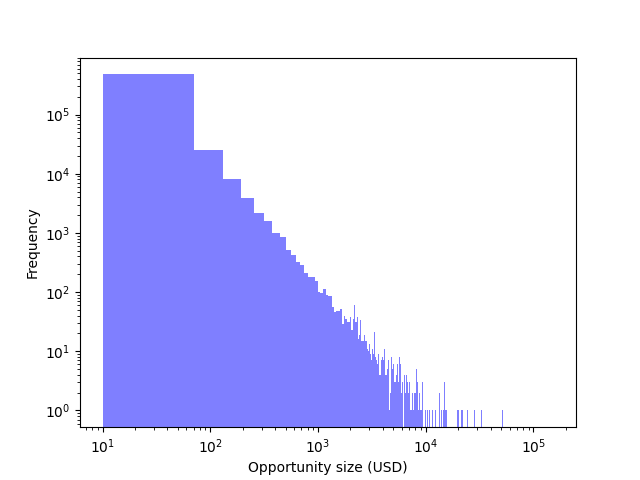

In [5]:
# Plot a "raw" opportunity histogram in log-log scale. "Raw" is used because
#  it treats each opportunity as a single data point, rather than aggregating
#  opportunity clusters, which is done below.
plt.figure()
n, bins, patches = plt.hist(opps_df['profit_usd'], bins=2500, facecolor='blue', alpha=0.5)
plt.xlabel('Opportunity size (USD)')
plt.ylabel('Frequency')
plt.xscale('log')
plt.yscale('log')
plt.show()

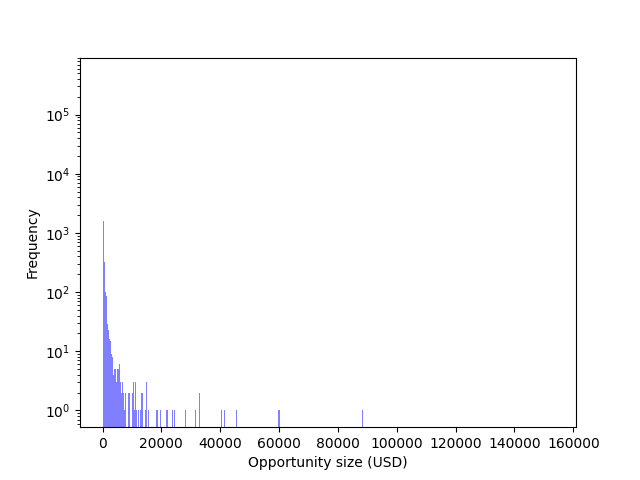

In [6]:
# Plot a "raw" opportunity histogram in log-scale.
plt.figure()
n, bins, patches = plt.hist(opps_df['profit_usd'], bins=2500, facecolor='blue', alpha=0.5)
plt.xlabel('Opportunity size (USD)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

In [7]:
# A token pair is often involved in multiple opportunities for a given block.
#   Ignore "inferior" opportunities that occur at the same timestamp as better ones.

# Get unique timestamps from `opps_df` archive.
unique_timestamps = opps_df['timestamp'].unique()

# Track the valid opportunities at each unique timestamp.
valid_opps = {}
for i, timestamp in enumerate(unique_timestamps):
    if np.isnan(timestamp):
        # This timestamp is invalid.
        print('found nan!')
        continue

    # Get opportunities that happen at the same time. Sort them by profit.
    opps_simultaneous = opps_df[opps_df['timestamp'] == timestamp].sort_values(
        by = 'profit_usd',
        ascending = False 
    )

    valid_opps[timestamp] = []

    # Track the swap IDs used at this timestamp. Only keep the opportunities that don't have 
    #   conflicting swap IDs.
    swap_ids_used = set()
    for j, opp in opps_simultaneous.iterrows():
        valid = 1
        swap_ids = opp[['swap_1_id', 'swap_2_id', 'swap_3_id', 'swap_4_id']].to_list()
        for id in swap_ids:
            # `swap_3_id` and `swap_4_id` could be 0 if not used. No need to track those.
            if (id == 0):
                break 
            # This ID is not used yet, so it is valid.
            elif id not in swap_ids_used:
                continue
            # This ID is used already, and it is conflicting with a greater opportunity.
            else:
                # No need to look further because this opportunity is inferior.
                valid = 0
                break
        
        # Add the swap ID to the set of used ones.
        if valid:
            swap_ids_used = swap_ids_used.union(set(swap_ids))
            valid_opps[timestamp].append(opp)
        else:
            pass 

found nan!


In [8]:
# Extracts details from the metadata associated with a swap ID.
def getSwapDetails(swap_metadata):
    chain = swap_metadata['chain'].iloc[0]
    dex = swap_metadata['dex'].iloc[0]
    token_in = swap_metadata['token_in_symbol'].iloc[0]
    token_out = swap_metadata['token_out_symbol'].iloc[0]
    return chain, dex, token_in, token_out

# Expands a list of swap IDs into a list of dictionaries with the metadata associated
#   with each swap ID.
def swapsIDsToPath(swap_ids):
    details = []
    for id in swap_ids:
        if id == 0:
            continue

        chain, dex, token_in, token_out = getSwapDetails(
            opps_metadata_df.loc[opps_metadata_df['swap_id'] == id]
        )
        
        details.append({'chain':chain, 'dex':dex, 'token_in':token_in, 'token_out':token_out})

    return details

# Converts a path from a csv string to a list.
def convertStringToList(path):
    return [int(float(k)) for k in path[1:-1].split(',')]

In [9]:
# Track the timestamps, profits, and block numbers where each opportunity occurs. 
path_data = {}
for timestamp, opps in valid_opps.items():
    for opp in opps: 
        path = str(opp[['swap_1_id', 'swap_2_id', 'swap_3_id', 'swap_4_id']].to_list())

        # Maps chains to the block numbers for the current opportunity
        block_numbers = opp[['swap_1_block', 'swap_2_block', 'swap_3_block', 'swap_4_block']].tolist()
        
        if path not in path_data:
            path_data[path] = {
                'timestamps': [timestamp], 
                'profit_usd': [opp['profit_usd']],
                'block_numbers': [block_numbers]
            }
        else:
            path_data[path]['timestamps'].append(timestamp)
            path_data[path]['profit_usd'].append(opp['profit_usd'])
            path_data[path]['block_numbers'].append(block_numbers)

In [10]:
# Sort the `path_data` by timestamps. Basically gets us a time series version of the data.
for path, data in path_data.items():
    timestamps = data['timestamps']
    profits = data['profit_usd']
    path_data[path]['timestamps'], path_data[path]['profits_usd'] = (
        list(t) for t in zip(*sorted(zip(timestamps, profits)))
    )

In [11]:
# Block rate (in seconds) for each chain that we track.
block_rate = {
    'polygon':2,
    'ethereum':12,
    'bsc':3,
    'fantom':3,
    'avalanche':1,
    'gnosis':5,
    'arbitrum':1,
    'optimism':2
}

In [12]:
# Todo: Clean this setion up. This is a hacky way to get the block numbers for each chain.
#   We should be able to get this from the archive node.

# Sanity check timestamps and block numbers for a random opportunity cluster
path = '[71.0, 80.0, 100.0, 84.0]'

# All we care about are what chains the IDs above map to, so we know what archive node to call.
swap_ids = convertStringToList(path)
swap_ids_metadata = swapsIDsToPath(swap_ids)
for metadata in swap_ids_metadata:
    print(metadata['chain'], end=' ')
print()

timestamps = path_data[path]['timestamps']
block_numbers = path_data[path]['block_numbers']
for timestamp, block_number_list in zip(timestamps, block_numbers):
    print(f'timestamp: {timestamp}, block numbers: {block_number_list}')

ethereum bsc ethereum bsc 
timestamp: 1667971179.0, block numbers: [15930345.0, 22898475.0, 15930345.0, 22898475.0]
timestamp: 1668354309.0, block numbers: [16110219.0, 23557417.0, 16110219.0, 23557417.0]
timestamp: 1668494661.0, block numbers: [16110220.0, 23557565.0, 16110220.0, 23557565.0]
timestamp: 1668501411.0, block numbers: [16110221.0, 23557680.0, 16110221.0, 23557680.0]
timestamp: 1668586023.0, block numbers: [16110294.0, 23564484.0, 16110294.0, 23564484.0]
timestamp: 1668840286.0, block numbers: [16110296.0, 23564656.0, 16110296.0, 23564656.0]
timestamp: 1668972293.0, block numbers: [16110297.0, 23564813.0, 16110297.0, 23564813.0]
timestamp: 1668972354.0, block numbers: [16110298.0, 23564932.0, 16110298.0, 23564932.0]
timestamp: 1668972367.0, block numbers: [16110299.0, 23565060.0, 16110299.0, 23565060.0]
timestamp: 1668972385.0, block numbers: [16110301.0, 23565345.0, 16110301.0, 23565345.0]
timestamp: 1668972411.0, block numbers: [16110302.0, 23565475.0, 16110302.0, 235654

In [13]:
# Stores opportunity clusters, which are clustered by relative profit and time.
unique_opps_profit_time = {}

# Loop through each path and assign its opportunities to a cluster.
for path, data in path_data.items():

    # Initialize the clustering dictionary for this path.
    unique_opps_profit_time[path] = {
        'profits':[],
        'timestamps': []
    }

    # Get the swap IDs used in the path.
    swap_ids = convertStringToList(path) 
    
    # Find the slowest chain in the path.
    slowest_block = 0
    for id in swap_ids:
        if id == 0:
            break

        # Get the chain name corresponding to the swap ID: Ethereum, Polygon, etc.
        chain_name = opps_metadata_df[opps_metadata_df['swap_id'] == id]['chain'].iloc[0]

        # Check if the current chain is the slowest in the path.
        if block_rate[chain_name] > slowest_block:
            slowest_block = block_rate[chain_name]
            slowest_chain = chain_name

    # Find all the opportunities and how long they persist when clustered.
    timestamps = data['timestamps']
    profits = data['profit_usd']
    profit_reference = profits[0] 
    time_reference = timestamps[0]

    # Variables used to track the current opportunity cluster.
    cluster_profits = [profits[0]]
    cluster_timestamps = [timestamps[0]]

    # Assign all opportunities in this path to a cluster.
    for i in range(1, len(timestamps)):
        current_profit = profits[i]
        current_time = timestamps[i]
        
        # If this opportunity is too different from the last opportunity in the current cluster, 
        #  store the current cluster and start a new one.

        # Current opportunity can be at most 10% different from the last opportunity in the cluster.
        propotion = current_profit / profit_reference
        max_deviation = .1

        # Current opportunity can be at most 100 seconds later than the last opportunity in the cluster.
        delta = current_time - time_reference 
        max_delta = 100

        # The following `if` logic runs whenever we need to store a cluster
        if propotion < (1 - max_deviation) or propotion > (1 + max_deviation) or delta > max_delta: 
            # Store the details of the current opportunity
            unique_opps_profit_time[path]['profits'].append(cluster_profits)
            unique_opps_profit_time[path]['timestamps'].append(cluster_timestamps)

            # Reset variables used to track next opportunity
            cluster_profits = [profits[i]]
            cluster_timestamps = [timestamps[i]]
        # The following logic runs when we assign an opportunity to an existing cluster
        else:
            cluster_profits.append(profits[i])
            cluster_timestamps.append(timestamps[i])
        
        # Reset the reference points
        profit_reference = current_profit
        time_reference = current_time

In [15]:
# Calculate more metadata for each opportunity cluster
for key, metadata in unique_opps_profit_time.items():
    max_profit_sum = 0
    min_profit_sum = 0
    opportunity_duration_sum = 0
    for timestamps, profits in zip(metadata['timestamps'], metadata['profits']):
        max_profit_sum += max(profits) 
        min_profit_sum += min(profits) 
        opportunity_duration_sum += len(timestamps)

    unique_opps_profit_time[key]['max_profit_sum'] = max_profit_sum
    unique_opps_profit_time[key]['min_profit_sum'] = min_profit_sum
    unique_opps_profit_time[key]['num_opportunities'] = len(metadata['profits'])
    unique_opps_profit_time[key]['opportunity_duration_sum'] = opportunity_duration_sum

    swap_ids = convertStringToList(key)
    unique_opps_profit_time[key]['path'] = swapsIDsToPath(swap_ids)

In [17]:
def profit_getter_max(item):
    return item[1]['max_profit_sum']

def profit_getter_min(item):
    return item[1]['min_profit_sum']

# Sort opportunity clusters by profit
sorted_by_profit = sorted(unique_opps_profit_time.items(), key=profit_getter_min, reverse=True)

# Print summary details about each opportunity cluster
total_max_profit = 0
for i, (key, metadata) in enumerate(sorted_by_profit):
    path = metadata['path'] 
    max_profit = metadata['max_profit_sum']

    total_max_profit += max_profit

    # todo: How can `max_profit` be zero? Is there a bug somewhere?
    if max_profit == 0:
        break

    min_profit = metadata['min_profit_sum']
    num_opportunities = metadata['num_opportunities'] 
    opportunity_duration_sum = metadata['opportunity_duration_sum']
    print(f'path {i+1}: {path}')
    print(f'key: {key}')
    print(f'total profit (max): ${int(max_profit):,}\ntotal profit (min): ${int(min_profit):,}\nopportunities: {num_opportunities}\navg. opportunity value (min): ${min_profit/num_opportunities:.2f}\navg. opportunity duration: {opportunity_duration_sum/num_opportunities:.2f} samples\n')

print('Total max profit', total_max_profit)
    
 

path 1: [{'chain': 'ethereum', 'dex': 'YouSwap', 'token_in': 'USDT', 'token_out': 'WETH'}, {'chain': 'bsc', 'dex': 'PancakeSwap V2', 'token_in': 'WETH', 'token_out': 'USDC'}, {'chain': 'ethereum', 'dex': 'LuaSwap', 'token_in': 'USDC', 'token_out': 'WETH'}, {'chain': 'bsc', 'dex': 'MDEX', 'token_in': 'WETH', 'token_out': 'USDT'}]
key: [74.0, 80.0, 100.0, 50.0]
total profit (max): $157,009
total profit (min): $154,887
opportunities: 133
avg. opportunity value (min): $1164.57
avg. opportunity duration: 1.35 samples

path 2: [{'chain': 'ethereum', 'dex': 'Defi Swap', 'token_in': 'DAI', 'token_out': 'WETH'}, {'chain': 'ethereum', 'dex': 'SushiSwap', 'token_in': 'WETH', 'token_out': 'USDT'}, {'chain': 'ethereum', 'dex': 'YouSwap', 'token_in': 'USDT', 'token_out': 'WETH'}, {'chain': 'ethereum', 'dex': 'ShibaSwap', 'token_in': 'WETH', 'token_out': 'DAI'}]
key: [231.0, 72.0, 74.0, 18.0]
total profit (max): $153,649
total profit (min): $153,643
opportunities: 25
avg. opportunity value (min): $61

[{'chain': 'ethereum', 'dex': 'SakeSwap', 'token_in': 'WBTC', 'token_out': 'WETH'}, {'chain': 'bsc', 'dex': 'PancakeSwap V2', 'token_in': 'WETH', 'token_out': 'USDC'}, {'chain': 'ethereum', 'dex': 'LuaSwap', 'token_in': 'USDC', 'token_out': 'WETH'}, {'chain': 'bsc', 'dex': 'PancakeSwap', 'token_in': 'WETH', 'token_out': 'BTCB'}]


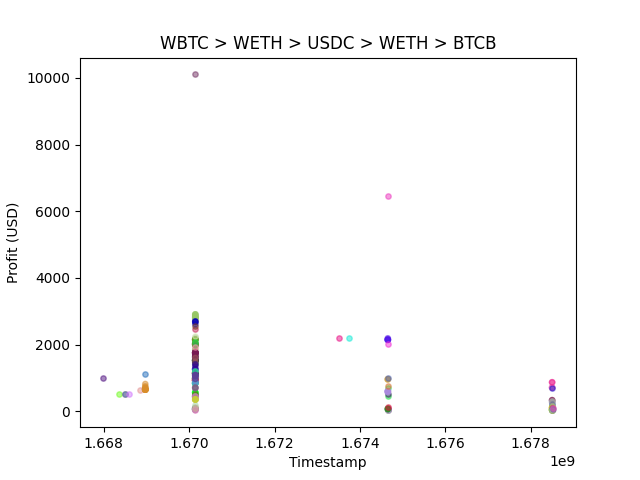

In [18]:
# Generate a time-profit plot for an opportunity cluster

key = '[71.0, 80.0, 100.0, 84.0]'
metadata = unique_opps_profit_time[key]
plt.figure()
for timestamps, profits in zip(metadata['timestamps'], metadata['profits']):
    plt.scatter(
        timestamps, 
        profits, 
        c=[(np.random.rand(),np.random.rand(),np.random.rand())]*len(timestamps),
        s=15,
        alpha=.5
    )

swaps = metadata['path']
title = ''
num_swaps = len(swaps)
for i in range(num_swaps):
    chain = swaps[i]['chain']
    dex = swaps[i]['dex']
    token_in = swaps[i]['token_in'] 
    token_out = swaps[i]['token_out']
    title += f'{token_in}'
    if i < num_swaps-1:
        title += ' > '
    else:
        title += f' > {token_out}'

plt.title(title)
plt.ylabel('Profit (USD)')
plt.xlabel('Timestamp')
plt.plot()
print(swaps)

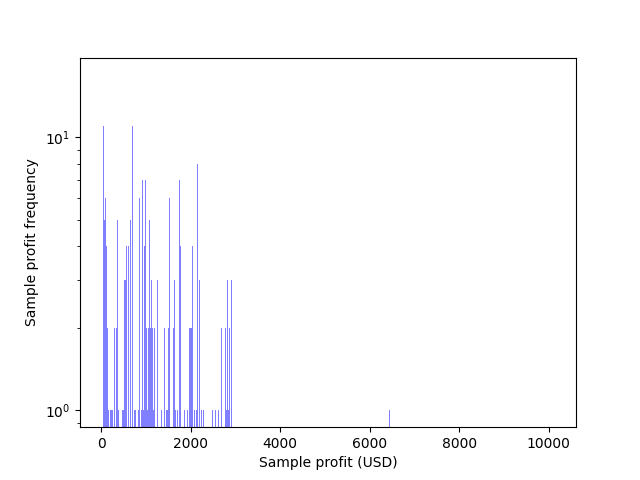

In [19]:
# Generate a profit histogram for an opportunity cluster

key = '[71.0, 80.0, 100.0, 84.0]'
metadata = unique_opps_profit_time[key]
sample_profits = [profit for sublist in metadata['profits'] for profit in sublist]
plt.figure()
n, bins, patches = plt.hist(sample_profits, bins=500, facecolor='blue', alpha=0.5)
plt.xlabel('Sample profit (USD)')
plt.ylabel('Sample profit frequency')
plt.yscale('log')
plt.show()

In [20]:
# Spot check an opportunity cluster

key = '[71.0, 80.0, 100.0, 84.0]'
metadata = unique_opps_profit_time[key]
for timestamps, profits in zip(metadata['timestamps'], metadata['profits']):
    plt.scatter(
        timestamps, 
        profits, 
        c=[(np.random.rand(),np.random.rand(),np.random.rand())]*len(timestamps),
        s=15,
        alpha=.5
    )

swaps = metadata['path']
title = ''
num_swaps = len(swaps)
for i in range(num_swaps):
    chain = swaps[i]['chain']
    dex = swaps[i]['dex']
    token_in = swaps[i]['token_in'] 
    token_out = swaps[i]['token_out']
    title += f'{token_in}'
    if i < num_swaps-1:
        title += ' > '
    else:
        title += f' > {token_out}'

plt.title(title)
plt.ylabel('Profit (USD)')
plt.xlabel('Timestamp')
plt.plot()
print(swaps)

[{'chain': 'ethereum', 'dex': 'SakeSwap', 'token_in': 'WBTC', 'token_out': 'WETH'}, {'chain': 'bsc', 'dex': 'PancakeSwap V2', 'token_in': 'WETH', 'token_out': 'USDC'}, {'chain': 'ethereum', 'dex': 'LuaSwap', 'token_in': 'USDC', 'token_out': 'WETH'}, {'chain': 'bsc', 'dex': 'PancakeSwap', 'token_in': 'WETH', 'token_out': 'BTCB'}]


Num. chains 1, Num. paths 34, Total profit $157090.99, Avg. profit per path $4620.32, Avg. duration per path 2.94 samples


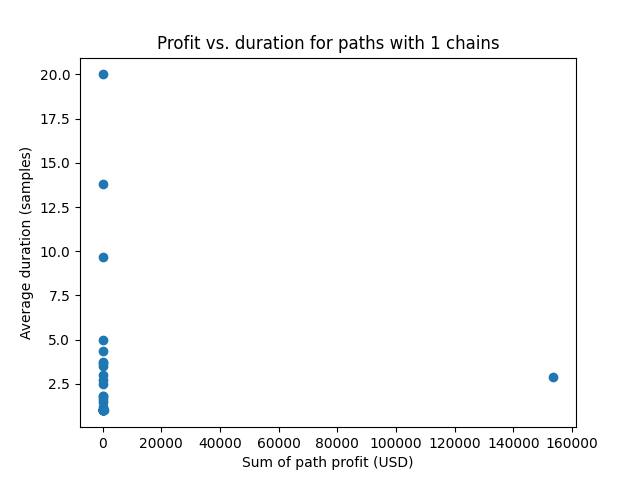

Num. chains 2, Num. paths 587, Total profit $1030462.14, Avg. profit per path $1755.47, Avg. duration per path 2.30 samples


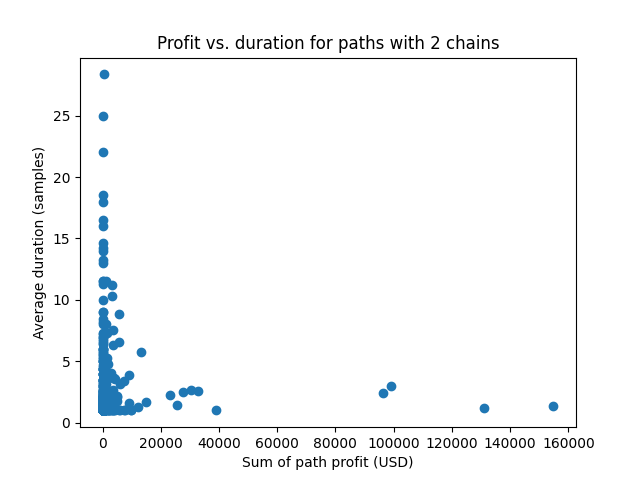

Num. chains 3, Num. paths 938, Total profit $814219.25, Avg. profit per path $868.04, Avg. duration per path 2.08 samples


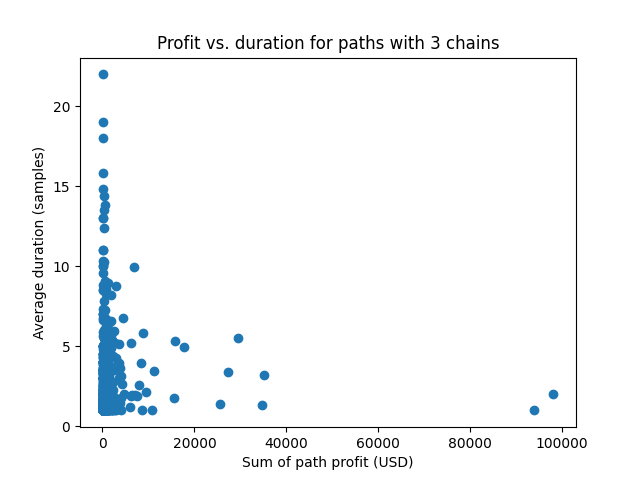

Num. chains 4, Num. paths 121, Total profit $38190.53, Avg. profit per path $315.62, Avg. duration per path 2.33 samples


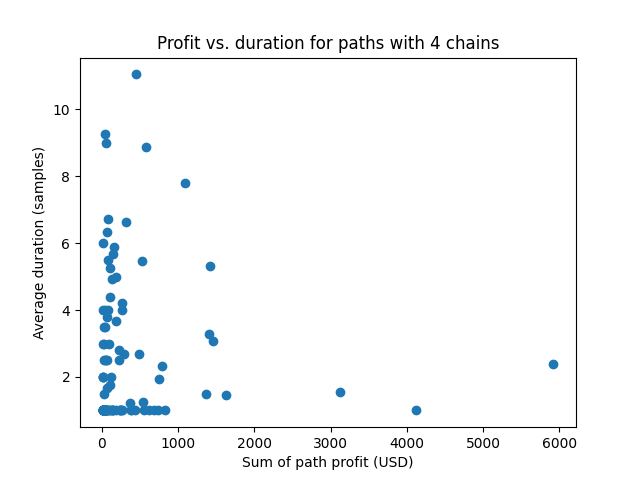

In [21]:
# Get the average duration of the opportunity as a function of the number chains involved

num_chains_stats = {}
for i, (key, metadata) in enumerate(sorted_by_profit):

    max_profit = metadata['max_profit_sum']
    if max_profit == 0:
        break
    
    opportunity_duration_sum = metadata['opportunity_duration_sum']
    num_opportunities = metadata['num_opportunities']
    avg_opportunity_duration =  opportunity_duration_sum/num_opportunities
    path = metadata['path']
    
    # Get the number of unique chains used in the path
    chains_seen = []
    for swap in path:
        chain = swap['chain']
        # Add the chain if we haven't seen it yet
        if chain not in chains_seen:
            chains_seen.append(chain)
        
    num_chains_in_path = len(chains_seen)

    if num_chains_in_path not in num_chains_stats.keys():
        num_chains_stats[num_chains_in_path] = {
            'min_profits':[],
            'avg_opportunity_duration':[],
            'num_paths':0
        }

    num_chains_stats[num_chains_in_path]['min_profits'].append(metadata['min_profit_sum'])
    num_chains_stats[num_chains_in_path]['avg_opportunity_duration'].append(avg_opportunity_duration)
    num_chains_stats[num_chains_in_path]['num_paths']+= metadata['num_opportunities']


# Count the number of opportunities corresponding to the number of chains
for num_chains_in_path in [1,2,3,4]:
    num_paths = len(num_chains_stats[num_chains_in_path]['min_profits'])
    avg_duration = sum(num_chains_stats[num_chains_in_path]['avg_opportunity_duration'])/num_paths
    total_profit = sum(num_chains_stats[num_chains_in_path]['min_profits'])
    print(f"Num. chains {num_chains_in_path}, Num. paths {num_paths}, Total profit ${total_profit:.2f}, Avg. profit per path ${total_profit/num_paths:.2f}, Avg. duration per path {avg_duration:.2f} samples")

    plt.figure()
    plt.title(f'Profit vs. duration for paths with {num_chains_in_path} chains')
    plt.scatter(num_chains_stats[num_chains_in_path]['min_profits'], num_chains_stats[num_chains_in_path]['avg_opportunity_duration'])
    plt.xlabel('Sum of path profit (USD)')
    plt.ylabel('Average duration (samples)')
    plt.show()
